<a href="https://colab.research.google.com/github/sy-hwang/DeepLearningZeroToAll/blob/master/standalone/lab_04_cifar10_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install pytorch for Google Colab

In [96]:
'''
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
'''

'\n!pip install -q torch==1.0.0 torchvision\nimport torch\nprint(torch.__version__)\n'

IMPORT

In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch.optim as optim
import torch.nn as nn
import torch.utils.data.dataloader

Hyperparameter

In [98]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.lr = 0.001
args.trainsize = 0.8
args.num_workers = 2
args.batch_size = 128
args.in_dim = 32*32*3
args.out_dim=10
args.hidden_dim=100
args.hidden_layer =3
args.act = 'relu'
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.momentum = 0.9
args.epoch=5
print(args)

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Namespace(act='relu', batch_size=128, device=device(type='cpu'), epoch=5, hidden_dim=100, hidden_layer=3, in_dim=3072, lr=0.001, momentum=0.9, num_workers=2, out_dim=10, trainsize=0.8)


Data generation

In [99]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainSet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainSize = int(args.trainsize*len(trainSet))
validateSize = len(trainSet)-trainSize
trainSet, validateSet = torch.utils.data.random_split(trainSet, [trainSize, validateSize])
testSet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
validateLoader = torch.utils.data.DataLoader(validateSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

print(f"set Nums : {len(trainSet), len(validateSet), len(testSet)}")
print(f"batchSize: {args.batch_size} / num Batches : {len(trainSet)//args.batch_size}, {len(validateSet)//args.batch_size}, {len(testSet)//args.batch_size}")

Files already downloaded and verified
Files already downloaded and verified
set Nums : (40000, 10000, 10000)
batchSize: 128 / num Batches : 312, 78, 78


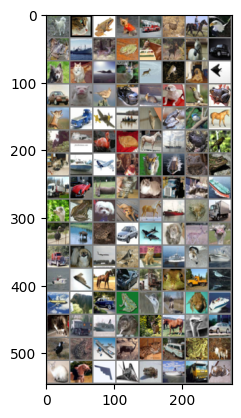

dog   cat   frog  dog   truck deer  horse bird  frog  ship  deer  frog  horse deer  horse car   dog   cat   plane deer  deer  frog  dog   plane car   dog   bird  car   deer  dog   bird  frog  deer  truck plane ship  bird  frog  bird  horse cat   cat   bird  cat   horse ship  frog  bird  cat   ship  plane cat   deer  ship  frog  frog  truck car   deer  cat   cat   truck cat   ship  bird  frog  dog   dog   horse ship  frog  truck bird  deer  frog  car   plane dog   deer  bird  truck dog   plane bird  cat   ship  dog   ship  ship  plane horse car   truck frog  truck bird  plane dog   car   frog  bird  horse frog  ship  cat   truck ship  bird  deer  horse bird  car   bird  frog  plane deer  cat   car   frog  deer  cat   horse plane plane frog  ship  truck cat  


In [100]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainLoader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(args.batch_size)))

In [101]:
print(type(images), images.shape) #batchsize =4, channnel=3, widthxheight=32x32
print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([128]) tensor([5, 3, 6, 5, 9, 4, 7, 2, 6, 8, 4, 6, 7, 4, 7, 1, 5, 3, 0, 4, 4, 6, 5, 0,
        1, 5, 2, 1, 4, 5, 2, 6, 4, 9, 0, 8, 2, 6, 2, 7, 3, 3, 2, 3, 7, 8, 6, 2,
        3, 8, 0, 3, 4, 8, 6, 6, 9, 1, 4, 3, 3, 9, 3, 8, 2, 6, 5, 5, 7, 8, 6, 9,
        2, 4, 6, 1, 0, 5, 4, 2, 9, 5, 0, 2, 3, 8, 5, 8, 8, 0, 7, 1, 9, 6, 9, 2,
        0, 5, 1, 6, 2, 7, 6, 8, 3, 9, 8, 2, 4, 7, 2, 1, 2, 6, 0, 4, 3, 1, 6, 4,
        3, 7, 0, 0, 6, 8, 9, 3])


Model define

In [102]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim, hidden_layer, act):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hidden_dim = hidden_dim
    self.hidden_layer = hidden_layer

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(in_dim, hidden_dim))
    for _ in range(hidden_layer-1):
      self.layers.append(nn.Linear(hidden_dim, hidden_dim))
    self.outlayer = nn.Linear(hidden_dim, out_dim)

    if(act == 'relu'):
      self.act = nn.ReLU()
    elif(act == 'sigmoid'):
      self.act = nn.Sigmoid()
    elif(act == 'tanh'):
      self.act = nn.Tanh()
    else:
      self.act = nn.ReLU()

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
      x = self.act(x)
    x = self.outlayer(x)
    return x

#model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.hidden_layer, args.act)
#model.to(args.device)
#print(model)

Loss and optimizer

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

Experiment

In [104]:
def train(model : MLP, loader:torch.utils.data.DataLoader, criterion:nn.Module, optimizer:optim.Optimizer):
    running_loss=0
    total=0
    correct = 0
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(args.device), labels.to(args.device)
        inputs = inputs.view(-1, args.in_dim)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss = running_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy
        
#loss, accuracy = train(model, trainLoader, criterion, optimizer)
#print(loss, accuracy)

In [105]:
def evaluate(model : MLP, loader:torch.utils.data.DataLoader, criterion:nn.Module, optimizer:optim.Optimizer):
    val_loss=0
    total=0
    correct = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(args.device), labels.to(args.device)
            inputs = inputs.view(-1, args.in_dim)

            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = val_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy
        
#loss, accuracy = train(model, validateLoader, criterion, optimizer)
#print(loss, accuracy)

In [106]:
def experiment():
    model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.hidden_layer, args.act)
    model.to(args.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    for epoch in range(args.epoch):
        trainLoss, trainAccuracy = train(model, trainLoader, criterion, optimizer)
        valLoss, valAccuracy = evaluate(model, validateLoader, criterion, optimizer)

        print(f"[{epoch}] trainLoss:{trainLoss}, trainAcc:{trainAccuracy}, valLoss:{valLoss}, valAcc:{valAccuracy}")

    _, testAccuracy = evaluate(model, testLoader, criterion, optimizer)
    return testAccuracy

#experiment()


In [107]:
layer_n=[3,4,5]
dim_n=[10, 50, 100]

for layer in layer_n:
    for dim in dim_n:
        args.hidden_layer = layer
        args.hidden_dim = dim
        print(f"{layer}, {dim} : {experiment()}")

[0] trainLoss:2.2911722462017314, trainAcc:11.915, valLoss:2.269788238066661, valAcc:11.91
[1] trainLoss:2.2438774238379238, trainAcc:14.54, valLoss:2.2200392379036433, valAcc:16.85
[2] trainLoss:2.1804478023760616, trainAcc:18.155, valLoss:2.1392675351492967, valAcc:19.77
[3] trainLoss:2.084892888800405, trainAcc:22.5925, valLoss:2.0403822705715515, valAcc:24.72
[4] trainLoss:2.0075538375507147, trainAcc:25.9625, valLoss:1.9835350090944315, valAcc:26.46
3, 10 : 26.93
[0] trainLoss:2.2875784464156665, trainAcc:13.5575, valLoss:2.263558384738391, valAcc:19.85
[1] trainLoss:2.2088156927127045, trainAcc:22.2675, valLoss:2.126183696939975, valAcc:23.16
[2] trainLoss:2.0614361831555352, trainAcc:24.7575, valLoss:2.003038972238951, valAcc:26.35


KeyboardInterrupt: 